# Chapter 16
## Ensemble methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

sns.set(style='whitegrid', palette='deep', font='sans-serif')

### Random forests

In [2]:
wine = pd.read_feather('../datasets/wine_quality.feather')
np.random.seed(42)

train = wine.groupby('quality').apply(lambda x: x.sample(frac=.7)).reset_index(drop=True)
test = wine[~wine.index.isin(train.index)]

X_train, X_test = train.iloc[:, 1:], test.iloc[:, 1:]
y_train, y_test = train.iloc[:, 0], test.iloc[:, 0]

In [3]:
series = [10, 25, 50, 100, 150, 200, 250, 300, 500]
test_scores = []
for param in series:
    rf = RandomForestRegressor(n_estimators=param, max_depth=14, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    test_scores.append(mean_absolute_error(y_test, rf.predict(X_test)))

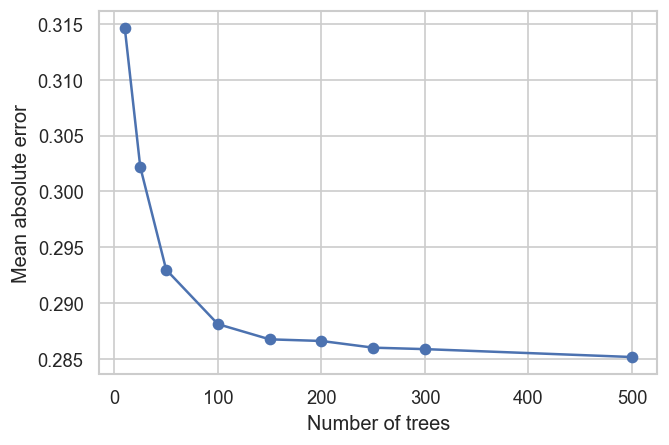

In [4]:
plt.subplots(dpi=120)
plt.plot(series, test_scores, '-o')
plt.xlabel('Number of trees')
plt.ylabel('Mean absolute error')
plt.show()

### Feature importance

In [5]:
rf = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

print(f"Test mean absolute error: {mean_absolute_error(y_test, rf.predict(X_test)):.3}")

Test mean absolute error: 0.228


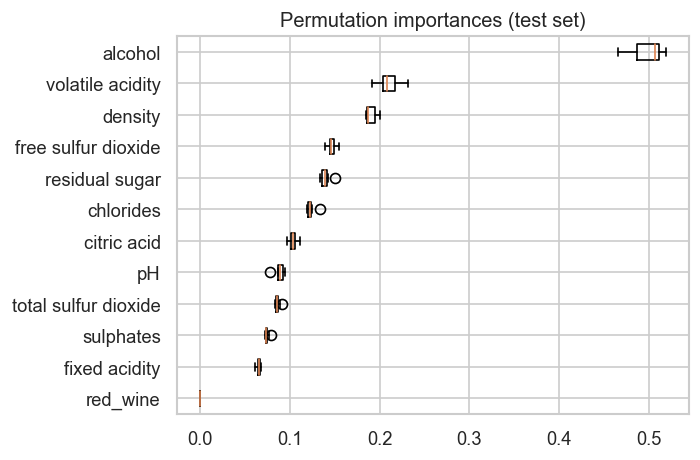

In [6]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(dpi=120)
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title('Permutation importances (test set)')
fig.tight_layout()
plt.show()

### Gradient boosting
#### AdaBoost

In [7]:
models = {
    'Decision trees': DecisionTreeRegressor(max_depth=14),
    'Linear Regression': make_pipeline(StandardScaler(), Ridge(alpha=1)),
    'kNN': KNeighborsRegressor(n_neighbors=1)
}
estimators = np.linspace(100, 500, 9).astype(int)
results = { 'Decision trees': [], 'Linear Regression': [], 'kNN': [] }

for label in models.keys():
    for n_estimators in estimators:
        model = AdaBoostRegressor(models[label], n_estimators=n_estimators, random_state=42)
        model.fit(X_train, y_train)
        results[label].append(mean_absolute_error(y_test, model.predict(X_test)))

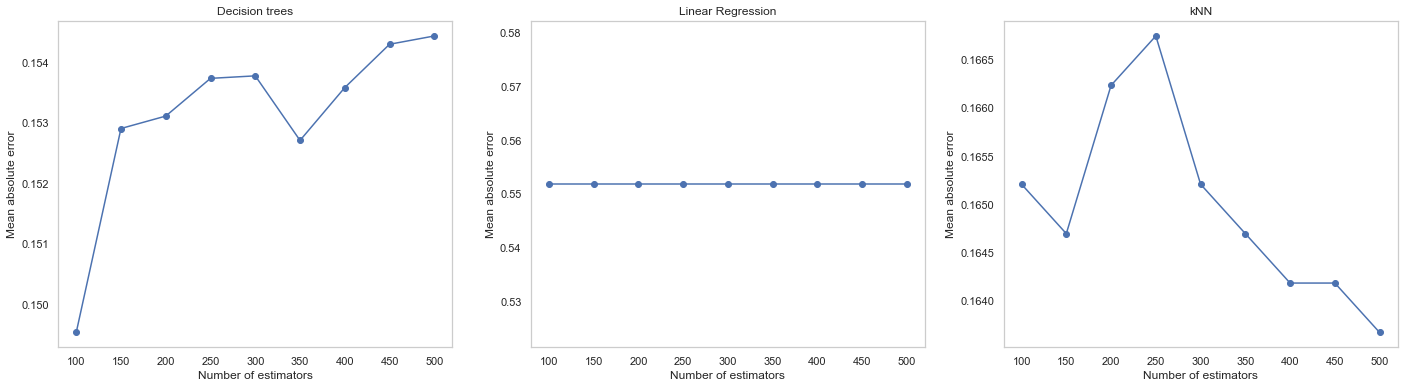

In [8]:
_, axs = plt.subplots(1, 3, figsize=(24, 6))
for ax, label in zip(axs, results.keys()):
    ax.plot(estimators, results[label], '-o')
    ax.set_title(label)
    ax.set_xlabel('Number of estimators')
    ax.set_ylabel('Mean absolute error')
    ax.grid()
plt.show()

In [9]:
estimators = np.linspace(1, 100, 99).astype(int)
result = []

for n_estimators in estimators:
    model = AdaBoostRegressor(make_pipeline(StandardScaler(), Ridge(alpha=1)), n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    result.append(mean_absolute_error(y_test, model.predict(X_test)))

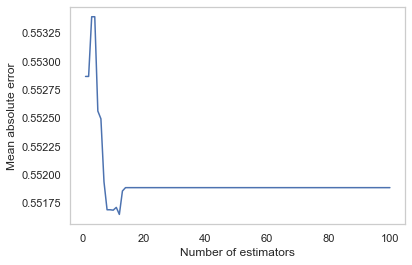

In [10]:
plt.plot(estimators, result, '-')
plt.xlabel('Number of estimators')
plt.ylabel('Mean absolute error')
plt.grid()
plt.show()

#### GBM

In [11]:
gbm = GradientBoostingRegressor(n_estimators=500, subsample=0.9, max_depth=12, learning_rate=0.1, random_state=42)
gbm.fit(X_train, y_train)
print(f"Test mean absolute error for GBM: {mean_absolute_error(y_test, gbm.predict(X_test)):.3}")

Test mean absolute error for GBM: 0.118


### Blending

In [12]:
gbm = GradientBoostingRegressor(n_estimators=500, subsample=0.9, max_depth=12, learning_rate=0.1, random_state=42)
svr = SVR(C=10, gamma=0.3, epsilon=1e-4)
blender = VotingRegressor(estimators=[('gbm', gbm), ('svm', svr)], n_jobs=-1)

blender.fit(X_train, y_train)
print(f"Test mean absolute error for blender: {mean_absolute_error(y_test, blender.predict(X_test)):.3}")

Test mean absolute error for blender: 0.115


### Stacking

In [13]:
gbm = GradientBoostingRegressor(n_estimators=500, subsample=0.9, max_depth=12, learning_rate=0.1, random_state=42)
svr = SVR(C=10, gamma=0.3, epsilon=1e-4)
sfk = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
stacker = StackingRegressor(estimators=[('svm', svr)], final_estimator=gbm, passthrough=True, cv=sfk, n_jobs=-1)

stacker.fit(X_train, y_train)
print(f"Test mean absolute error for stacker: {mean_absolute_error(y_test, stacker.predict(X_test)):.3}")

Test mean absolute error for stacker: 0.182
